In [1]:
import sys
import os

In [2]:
sys.path.append(os.path.abspath('../'))

In [3]:
# Quick prototyping:
%reload_ext autoreload
%autoreload 2

In [4]:
import matplotlib.pyplot as plt

In [5]:
# LaTeX rendering in graphs
try:
    plt.rc('text', usetex=True)
except:
    pass

plt.rc('font', family='serif')

# High resolution graphs
%config InlineBackend.figure_format = 'retina'

In [6]:
import models

from utils.clusters import ClusterHelper, ClusterModel
from utils.dataset import HoromaDataset, SplitDataset, FullDataset
from utils.transforms import HoromaTransforms

In [7]:
import json
import numpy as np

In [8]:
import torch

from torch.utils.data import DataLoader
from torchvision import transforms

In [9]:
import pickle

In [10]:
from sklearn import metrics
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
def retrieve_config(name):
    with open(name, 'r') as f:
        conf = json.load(f)
    return conf

In [13]:
def get_model(conf):
    return getattr(models, conf['model']['type'])(**conf['model']['args'])

In [14]:
log_folder = '/Users/basile/Documents/Helios/horoma/logs/cnnautoencoder_cluster_kmeans_l40/0312_211237/'

In [15]:
config = retrieve_config(log_folder + 'config.json')

In [16]:
model = torch.load(
    log_folder + 'bare_model.pth', 
    map_location='cpu'
)

/Users/basile/miniconda3/envs/pytorch/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'models.conv_ae.ConvolutionalAutoEncoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [17]:
model

ConvolutionalAutoEncoder(
  (loss_fct): MSELoss()
  (dropout): Dropout(p=0.1)
  (encode_cnn_1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (encode_cnn_2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (encode_lin_1): Linear(in_features=500, out_features=50, bias=True)
  (encode_lin_2): Linear(in_features=50, out_features=40, bias=True)
  (decode_lin_1): Linear(in_features=40, out_features=500, bias=True)
  (decode_lin_2): Linear(in_features=500, out_features=3072, bias=True)
)

In [17]:
labelled = HoromaDataset(
    '/Users/basile/Documents/Helios/data/horoma/', 
    split='valid_overlapped',
    transforms=HoromaTransforms()
)
# labelled = FullDataset(labelled)

loader = DataLoader(labelled, batch_size=100, shuffle=False)

In [22]:
with open('/Users/basile/Documents/Helios/horoma/baseline/pca.pkl', 'rb') as f:
    pca = pickle.load(f)

In [36]:
dataset = []
labels = []

model.eval()

with torch.no_grad():
    
    for data, label in loader:
        
        data = data.to(device)
        
        model.encode_cnn_1(data)
        
        z = model.encode(data).cpu()
        dataset.append(z.detach().numpy())
        labels.append(label.numpy())

dataset = np.concatenate(dataset)
labels = np.concatenate(labels).reshape(-1).astype(int)

In [37]:
dataset.shape

(1331, 40)

In [38]:
labels.shape

(1331,)

In [39]:
tsne = TSNE()

In [40]:
embedding = tsne.fit_transform(dataset)

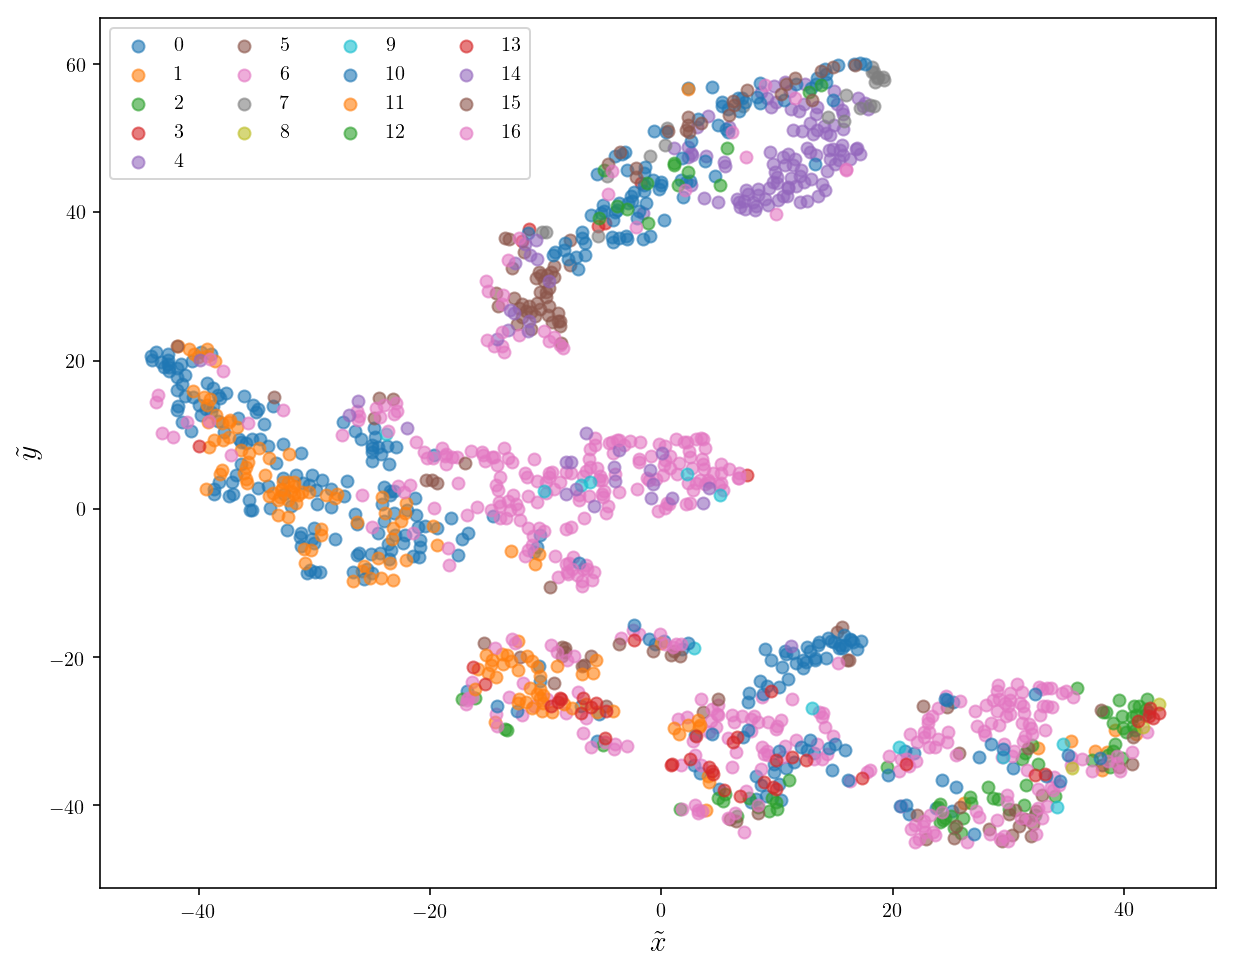

In [41]:
plt.figure(figsize=(10, 8))

for label in np.unique(labels):
    
    x, y = embedding[labels == label].T
    plt.scatter(x, y, label='{}'.format(label), alpha=.6)
    
plt.legend(ncol=4)

plt.xlabel(r'$\tilde{x}$', size=15)
plt.ylabel(r'$\tilde{y}$', size=15)

plt.savefig('outputs/tsne-ae.pdf', bbox_inches='tight')

plt.show()

In [29]:
dataset = pca.transform(labelled.data.reshape(len(labelled), -1))

In [30]:
dataset.shape

(1331, 27)

In [31]:
labels.shape

(1331,)

In [32]:
tsne = TSNE()

In [33]:
embedding = tsne.fit_transform(dataset)

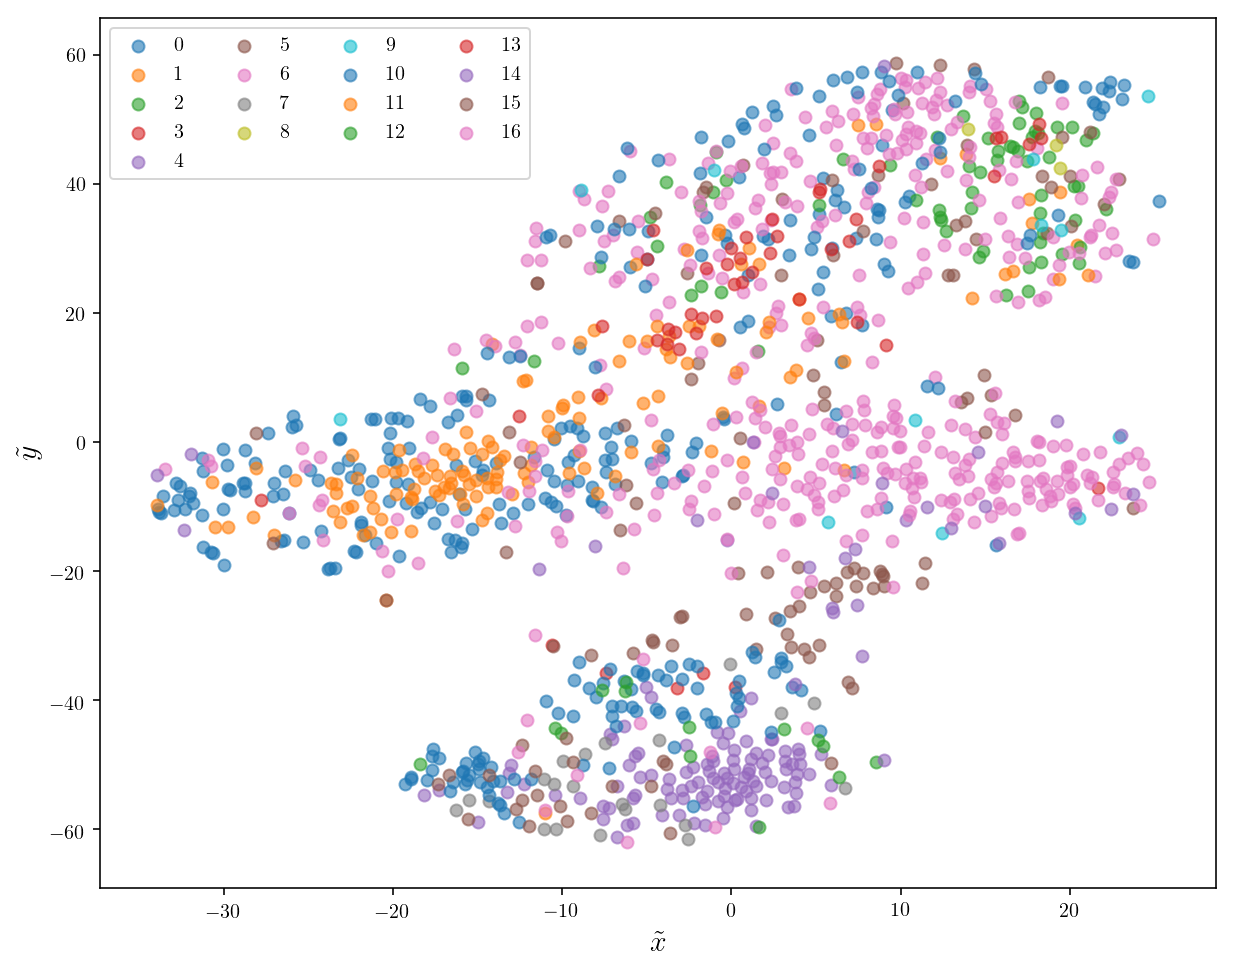

In [35]:
plt.figure(figsize=(10, 8))

for label in np.unique(labels):
    
    x, y = embedding[labels == label].T
    plt.scatter(x, y, label='{}'.format(label), alpha=.6)
    
plt.legend(ncol=4)

plt.xlabel(r'$\tilde{x}$', size=15)
plt.ylabel(r'$\tilde{y}$', size=15)

plt.savefig('outputs/tsne-pca.pdf', bbox_inches='tight')

plt.show()

In [42]:
dataset = labelled.data.reshape(len(labelled), -1)

In [43]:
dataset.shape

(1331, 3072)

In [44]:
labels.shape

(1331,)

In [45]:
tsne = TSNE()

In [46]:
embedding = tsne.fit_transform(dataset)

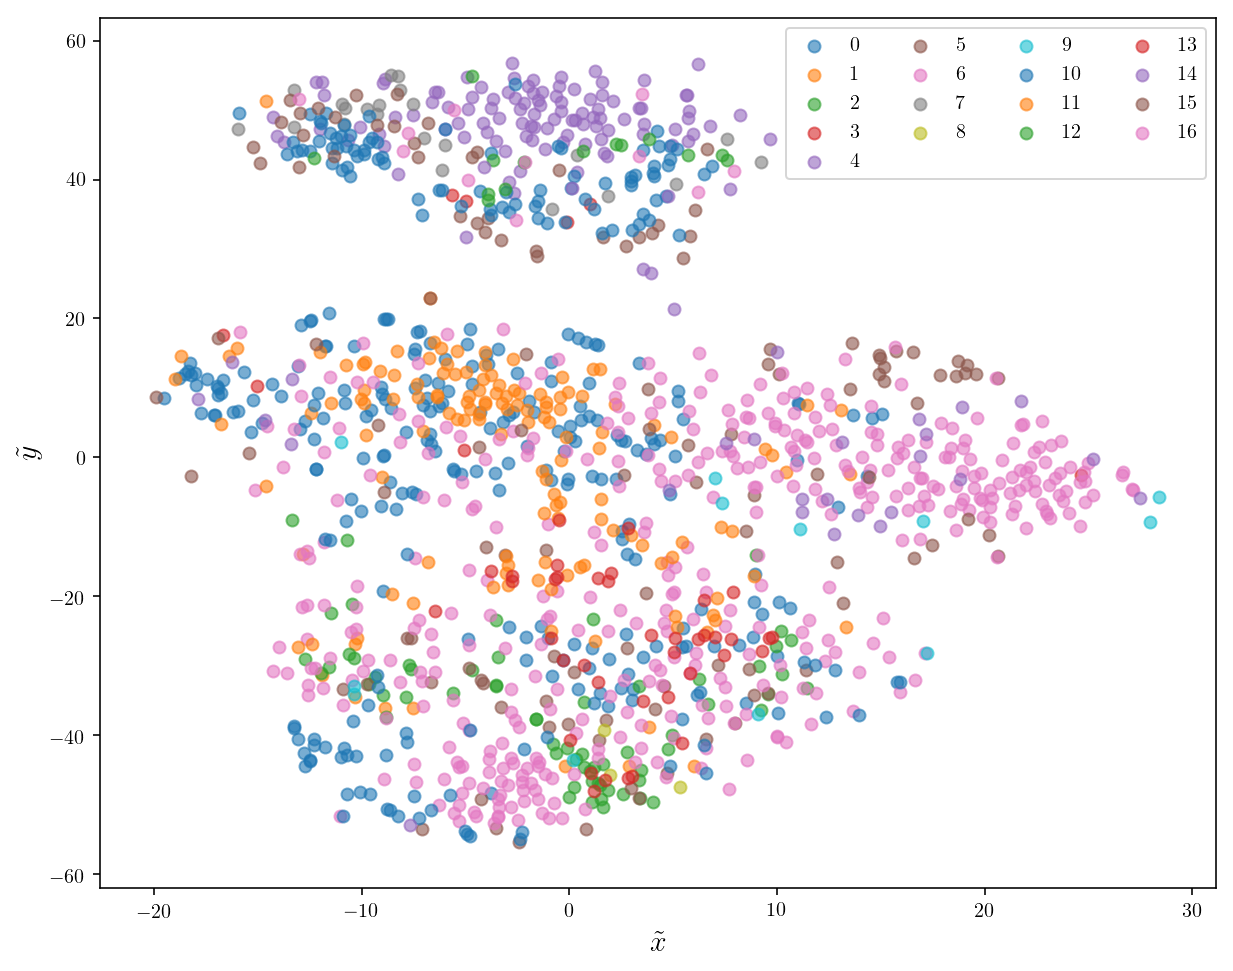

In [47]:
plt.figure(figsize=(10, 8))

for label in np.unique(labels):
    
    x, y = embedding[labels == label].T
    plt.scatter(x, y, label='{}'.format(label), alpha=.6)
    
plt.legend(ncol=4)

plt.xlabel(r'$\tilde{x}$', size=15)
plt.ylabel(r'$\tilde{y}$', size=15)

plt.savefig('outputs/tsne-fulldim.pdf', bbox_inches='tight')

plt.show()

In [57]:
unlabelled = HoromaDataset(
    '/Users/basile/Documents/Helios/data/horoma/', 
    split='train_overlapped',
    transforms=HoromaTransforms()
)

labelled = HoromaDataset(
    '/Users/basile/Documents/Helios/data/horoma/', 
    split='valid_overlapped',
    transforms=HoromaTransforms()
)

_, unlabelled = SplitDataset(.95)(unlabelled)
train, valid = SplitDataset(.7)(labelled)

unlabelled_loader = DataLoader(unlabelled, shuffle=False, batch_size=100)
train_loader = DataLoader(train, shuffle=False, batch_size=100)
valid_loader = DataLoader(valid, shuffle=False, batch_size=100)

In [58]:
len(unlabelled)

27436

In [59]:
cluster_helper = ClusterHelper(
    model=model, 
    device=device, 
    unlabelled_loader=unlabelled_loader, 
    valid_loader=valid_loader, 
    train_loader=train_loader
)

Getting train_labels...
Getting train_labels...


In [60]:
cluster_helper.build_embeddings()

In [61]:
kmeans = ClusterModel(KMeans(n_clusters=200), cluster_helper=cluster_helper)

Fitting the KMeans model

In [62]:
kmeans.full_fit()

In [63]:
(kmeans.labelled_predict(cluster_helper.valid_embedding) == cluster_helper.valid_labels).mean()

0.3856812933025404

In [64]:
(kmeans.labelled_predict(cluster_helper.train_embedding) == cluster_helper.train_labels).mean()

0.6570155902004454